Setup and Load data

In [ ]:
!pip install tensorflow opencv-python matplotlib
!pip install -q tensorflow-datasets

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
ds, ds_info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
  )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.HCNPP6_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
print(ds_info)

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

Removing corrupt images

In [ ]:
import cv2
from PIL import Image

In [ ]:
import zipfile
import os

# Path to the zip file
zip_path = "/root/tensorflow_datasets/downloads/cats_vs_dogs/down.micr.com_down_3_E_1_3E1C-ECDB-4869-83t5dL0AqEqZkh827kQD8ImFN3e1ro0VHHaobmSQAzSvk.zip"

# Destination directory
extract_to = "/root/ImageClassification"
os.makedirs(extract_to, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Zip extracted to:", extract_to)

Zip extracted to: /root/ImageClassification


In [ ]:
data_dir ='/root/ImageClassification/PetImages'

In [ ]:
def thorough_image_cleanup(data_dir):
    """Comprehensive image cleanup that removes all problematic files"""
    if not os.path.exists(data_dir):
        print(f"Directory {data_dir} does not exist!")
        return False

    valid_extensions = {'.jpg', '.jpeg', '.png', '.bmp'}
    removed_count = 0
    total_processed = 0

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"Processing {class_name} folder...")

        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            total_processed += 1

            # Check file extension
            _, ext = os.path.splitext(filename.lower())
            if ext not in valid_extensions:
                print(f"Removing non-image file: {filename}")
                os.remove(file_path)
                removed_count += 1
                continue

            # Validate image
            is_valid = validate_image(file_path, filename)

            if not is_valid:
                try:
                    os.remove(file_path)
                    removed_count += 1
                    print(f"Removed corrupted file: {filename}")
                except Exception as rm_error:
                    print(f"Could not remove: {filename}, error: {rm_error}")

    print(f"Processed {total_processed} files, removed {removed_count} corrupted files")
    return True

def validate_image(file_path, filename):
    """Validate a single image file"""
    try:
        # Check file size
        if os.path.getsize(file_path) < 100:  # Less than 100 bytes
            print(f"File too small: {filename}")
            return False

        # PIL validation
        with Image.open(file_path) as img:
            img.verify()

        # Reopen and load
        with Image.open(file_path) as img:
            img.load()

            # Check dimensions
            if img.size[0] < 10 or img.size[1] < 10:
                print(f"Image too small: {filename}")
                return False

            # Convert problematic modes
            if img.mode not in ['RGB', 'L', 'RGBA']:
                print(f"Converting {img.mode} to RGB: {filename}")
                rgb_img = img.convert('RGB')
                rgb_img.save(file_path)

        # OpenCV validation
        cv_img = cv2.imread(file_path)
        if cv_img is None:
            print(f"OpenCV cannot read: {filename}")
            return False

        # TensorFlow validation
        try:
            img_raw = tf.io.read_file(file_path)
            img_tensor = tf.image.decode_image(img_raw, channels=3)
            img_resized = tf.image.resize(img_tensor, [256, 256])
            _ = tf.reduce_mean(img_resized).numpy()
        except Exception as tf_error:
            print(f"TensorFlow cannot decode: {filename}, error: {tf_error}")
            return False

        return True

    except Exception as e:
        print(f"General error with {filename}: {e}")
        return False

print("Image validation functions ready!")

Image validation functions ready!


In [ ]:
print("Starting image cleanup...")
cleanup_success = thorough_image_cleanup(data_dir)

if cleanup_success:
    # Print final counts
    final_total = 0
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            count = len([f for f in os.listdir(class_path)
                        if os.path.isfile(os.path.join(class_path, f))])
            final_total += count
            print(f"{class_name}: {count} images remaining")

    print(f"Total valid images: {final_total}")
else:
    print("Cleanup failed!")

Starting image cleanup...
Processing Dog folder...
Converting P to RGB: 5604.jpg
Converting P to RGB: 2877.jpg
TensorFlow cannot decode: 9500.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Removed corrupted file: 9500.jpg
Converting P to RGB: 1308.jpg
Converting P to RGB: 3288.jpg
Converting P to RGB: 3588.jpg
Converting P to RGB: 2384.jpg
Converting P to RGB: 7369.jpg
Converting P to RGB: 7112.jpg
Converting P to RGB: 7459.jpg
Converting P to RGB: 6059.jpg
Converting P to RGB: 3136.jpg
Converting P to RGB: 11849.jpg
Converting P to RGB: 11853.jpg
Converting P to RGB: 7133.jpg
Converting P to RGB: 10797.jpg
Converting P to RGB: 8730.jpg
Converting P to RGB: 9188.jpg
TensorFlow cannot decode: 2494.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Input size should match (header_size + ro

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


TensorFlow cannot decode: 11233.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Removed corrupted file: 11233.jpg
Converting P to RGB: 2688.jpg
Converting P to RGB: 6718.jpg
Removing non-image file: Thumbs.db
File too small: 11702.jpg
Removed corrupted file: 11702.jpg
Converting P to RGB: 6318.jpg
Converting P to RGB: 5736.jpg
Converting P to RGB: 6238.jpg
TensorFlow cannot decode: 2317.jpg, error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Number of channels inherent in the image must be 1, 3 or 4, was 2 [Op:DecodeImage] name: 
Removed corrupted file: 2317.jpg
Converting CMYK to RGB: 6245.jpg
Processing Cat folder...
Converting P to RGB: 6435.jpg
Converting P to RGB: 7968.jpg
Converting P to RGB: 12080.jpg
File too small: 666.jpg
Removed corrupted file: 666.jpg
Converting P to RGB: 850.jpg
C

In [ ]:
IMG_SIZE = 256
BATCH_SIZE = 16
def create_normalized_dataset_optimized(data_dir):
    """Create dataset with proper normalization and memory optimization"""
    try:
        # Create base dataset with smaller parameters
        dataset = tf.keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=None,
            subset=None,
            image_size=(IMG_SIZE, IMG_SIZE),  # Use the same size as raw dataset
            batch_size=BATCH_SIZE,           # Use the same batch size
            shuffle=True,
            seed=123,
            interpolation='bilinear'
        )

        # Memory-efficient normalization
        def normalize_img(image, label):
            # Convert to float32 and normalize to [0,1]
            image = tf.cast(image, tf.float32) / 255.0
            return image, label

        # Apply normalization without caching to save memory
        dataset = dataset.map(normalize_img)
        return dataset

    except Exception as e:
        print(f"Normalized dataset creation failed: {e}")
        return None

# Create normalized dataset
data2 = create_normalized_dataset_optimized(data_dir)

Found 24990 files belonging to 2 classes.


Load data pipeline,allowing access and accessing

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
data=tf.keras.utils.image_dataset_from_directory('/root/ImageClassification/PetImages')

Found 24990 files belonging to 2 classes.


In [ ]:
data_iterator=data.as_numpy_iterator()

In [ ]:
batch=data_iterator.next()

In [ ]:
len(batch)

2

In [ ]:
#Class 0 = cat
#Class 1 = dog
batch[1]

array([0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype=int32)

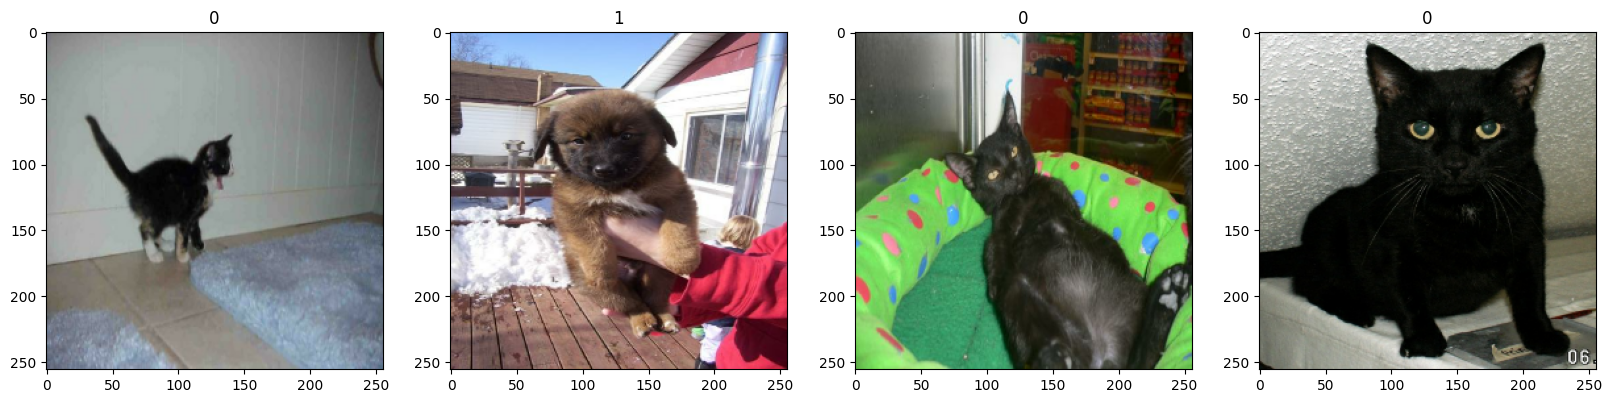

In [ ]:
fig, ax =plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(batch[1][idx])

Preprocessing the data

In [ ]:
data1=data.map(lambda x,y:(x/255 ,y))

In [ ]:
scaled_iterator=data1.as_numpy_iterator().next()

In [ ]:
scaled_iterator[0].max()

np.float32(1.0)

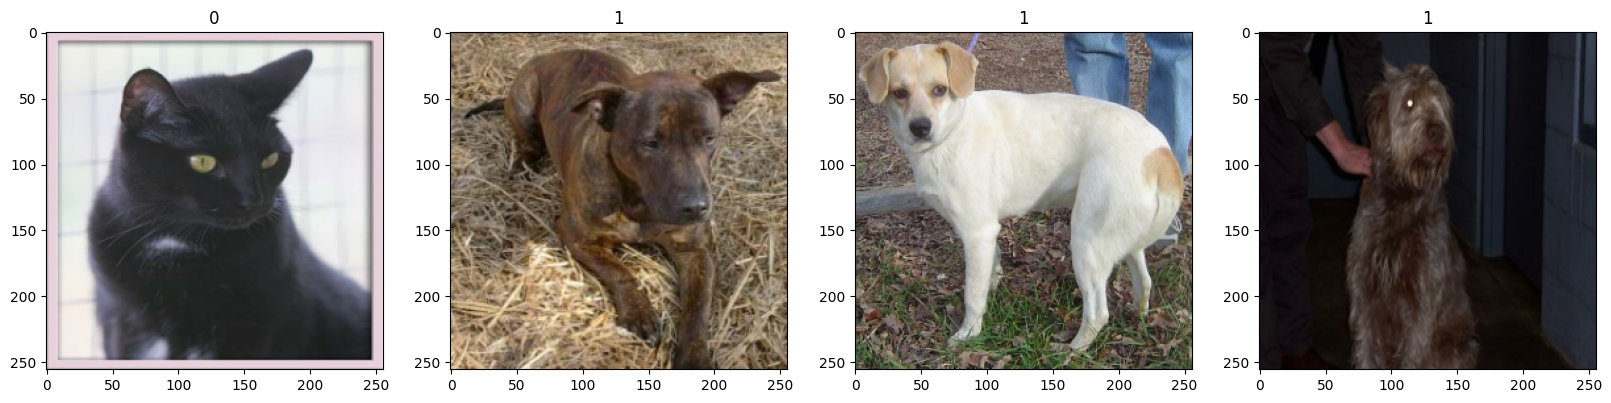

In [ ]:
fig, ax =plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(scaled_iterator[0][:4]):
  ax[idx].imshow(img)
  ax[idx].title.set_text(scaled_iterator[1][idx])

In [ ]:
len(data)

781

In [ ]:
len(data1)

781

In [ ]:
train_size=int(len(data2)*.7)
val_size=int(len(data2)*.2)
test_size=int(len(data2)*.1)+1

In [ ]:
train=data2.take(train_size)
val=data2.skip(train_size).take(val_size)
test=data2.skip(train_size+val_size).take(test_size)

Building model

In [ ]:
train_size + val_size + test_size

1562

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.regularizers import l2

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', activation='relu', input_shape=(256,256,3), kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())
model.add(Dropout(0.3))

model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', activation='relu', kernel_regularizer=l2(0.001)))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,204,529 (16.04 MB)

 Trainable params: 4,204,529 (16.04 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
log_dir ="/root/ImageClassification/logs"
os.makedirs(log_dir,exist_ok=True)

In [ ]:
tensorboard_callback=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
                      tf.keras.callbacks.TensorBoard(log_dir),
                      tf.keras.callbacks.ReduceLROnPlateau(patience=3, factor=0.5)]

In [ ]:
hist = model.fit(train, epochs=20,validation_data= val,callbacks=[tensorboard_callback])

Epoch 1/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 63s 51ms/step - accuracy: 0.5357 - loss: 0.8545 - val_accuracy: 0.6180 - val_loss: 0.6757 - learning_rate: 0.0010
Epoch 2/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 67s 62ms/step - accuracy: 0.5861 - loss: 0.7013 - val_accuracy: 0.6228 - val_loss: 0.6775 - learning_rate: 0.0010
Epoch 3/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.6574 - loss: 0.6574 - val_accuracy: 0.6837 - val_loss: 0.6197 - learning_rate: 0.0010
Epoch 4/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 55s 50ms/step - accuracy: 0.6901 - loss: 0.6292 - val_accuracy: 0.7131 - val_loss: 0.6154 - learning_rate: 0.0010
Epoch 5/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 56s 51ms/step - accuracy: 0.7189 - loss: 0.6092 - val_accuracy: 0.7460 - val_loss: 0.5834 - learning_rate: 0.0010
Epoch 6/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 55s 51ms/step - accuracy: 0.7520 - loss: 0.5839 - val_accuracy: 0.7378 - val_loss: 0.5995 - learning_rate: 0.0010
Epoch 7/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 69s 63ms/step - accura

In [ ]:
hist.history

{'accuracy': [0.5546088814735413,
  0.6044716238975525,
  0.67023104429245,
  0.7016811370849609,
  0.7345036864280701,
  0.7590347528457642,
  0.767612099647522,
  0.7733302712440491,
  0.7823650240898132,
  0.7825366258621216,
  0.7853956818580627,
  0.7884835600852966,
  0.7913998365402222,
  0.7951738238334656,
  0.7972323894500732,
  0.8163883686065674,
  0.8178750872612,
  0.8237076997756958,
  0.827252984046936,
  0.8314844369888306],
 'loss': [0.7516376376152039,
  0.6924765110015869,
  0.6463137269020081,
  0.6228078603744507,
  0.5967738628387451,
  0.5765925049781799,
  0.5675151944160461,
  0.5573527812957764,
  0.5533687472343445,
  0.5473734140396118,
  0.5457697510719299,
  0.5438948273658752,
  0.5378663539886475,
  0.5351947546005249,
  0.5316639542579651,
  0.49303603172302246,
  0.4796695411205292,
  0.47529110312461853,
  0.46680083870887756,
  0.46395400166511536],
 'val_accuracy': [0.6179887652397156,
  0.6227964758872986,
  0.6836938858032227,
  0.713141024112701

Evaluation

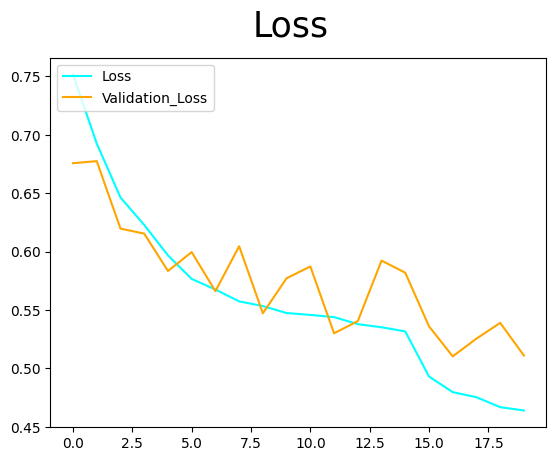

In [ ]:
fig=plt.figure()
plt.plot(hist.history['loss'],color = 'cyan', label ='Loss')
plt.plot(hist.history['val_loss'],color = 'orange', label ='Validation_Loss')
plt.suptitle('Loss',fontsize='25')
plt.legend(loc='upper left')
plt.show()

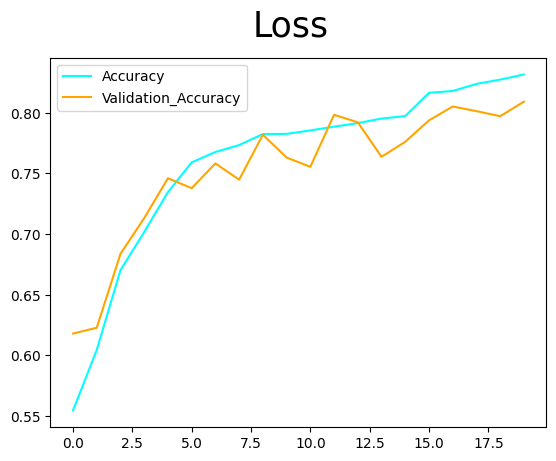

In [ ]:
fig=plt.figure()
plt.plot(hist.history['accuracy'],color = 'cyan', label ='Accuracy')
plt.plot(hist.history['val_accuracy'],color = 'orange', label ='Validation_Accuracy')
plt.suptitle('Loss',fontsize='25')
plt.legend(loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision,BinaryAccuracy,Recall

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
for scaled_iterator in test.as_numpy_iterator():
  X,y = scaled_iterator
  yhat = model.predict(X)
  pre.update_state(y,yhat)
  re.update_state(y,yhat)
  acc.update_state(y,yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [ ]:
print(f'Precision:{pre.result().numpy()},Recall:{re.result().numpy()},Accuracy:{acc.result().numpy()}')

Precision:0.8465608358383179,Recall:0.7547169923782349,Accuracy:0.8063744902610779


Testing

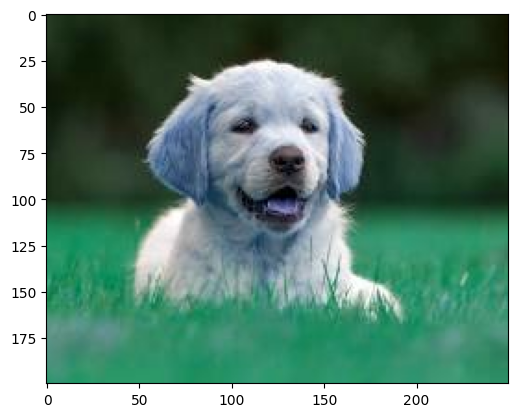

In [ ]:
img=cv2.imread('/content/dogtest.jpeg')
plt.imshow(img)
plt.show()

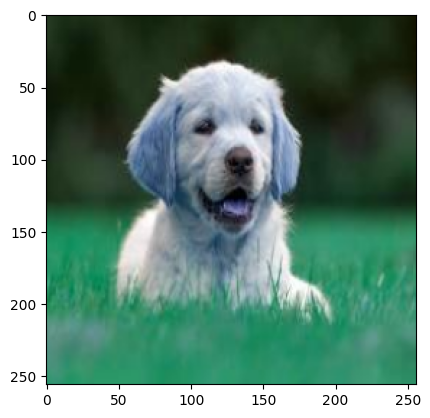

In [ ]:
resize = tf.image.resize(img,(256,256))
#plt.imshow(img/255)
plt.imshow(resize.numpy().astype(int))
plt.show()

In [ ]:
yhat=model.predict(np.expand_dims(resize/255,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


In [ ]:
yhat

array([[0.92015743]], dtype=float32)

In [ ]:
if yhat > 0.5:
    print(f'Predicted class is Dog')
else:
    print(f'Predicted class is Cat')

Predicted class is Dog
